<a href="https://colab.research.google.com/github/MehrdadDastouri/advanced_cnn_cifar10/blob/main/advanced_cnn_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


100%|██████████| 170M/170M [00:05<00:00, 32.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20], Train Loss: 1.6497, Test Loss: 1.3005, Test Accuracy: 51.80%
Epoch [2/20], Train Loss: 1.3002, Test Loss: 1.0580, Test Accuracy: 60.96%
Epoch [3/20], Train Loss: 1.1473, Test Loss: 0.9196, Test Accuracy: 67.97%
Epoch [4/20], Train Loss: 1.0502, Test Loss: 0.8695, Test Accuracy: 68.38%
Epoch [5/20], Train Loss: 0.9785, Test Loss: 0.7892, Test Accuracy: 72.68%
Epoch [6/20], Train Loss: 0.9184, Test Loss: 0.7410, Test Accuracy: 73.81%
Epoch [7/20], Train Loss: 0.8742, Test Loss: 0.7603, Test Accuracy: 73.52%
Epoch [8/20], Train Loss: 0.8181, Test Loss: 0.7505, Test Accuracy: 75.22%
Epoch [9/20], Train Loss: 0.7846, Test Loss: 0.6652, Test Accuracy: 77.53%
Epoch [10/20], Train Loss: 0.7493, Test Loss: 0.6323, Test Accuracy: 78.43%
Epoch [11/20], Train Loss: 0.7188, Test Loss: 0.6032, Test Accuracy: 79.77%
Epoch [12/20], Train Loss: 0.6851, Test Loss: 0.6079, Test Accuracy: 79.32%
Epoch [1

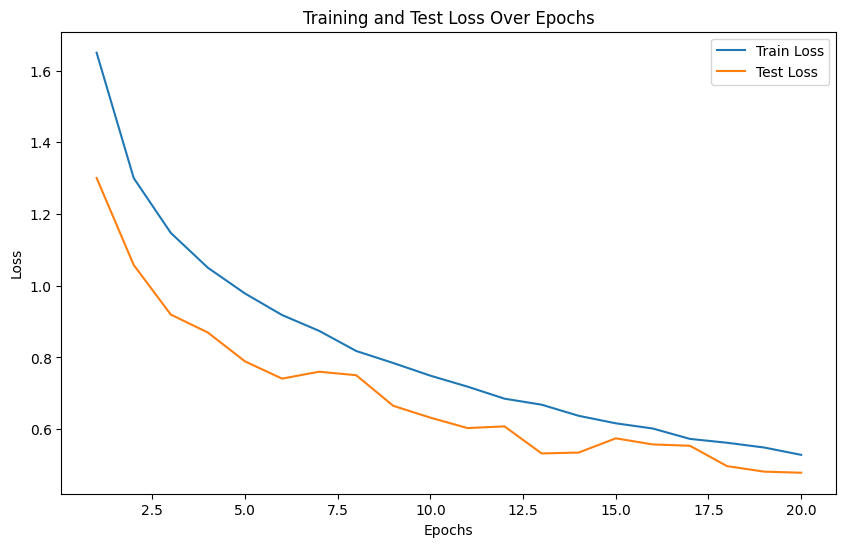

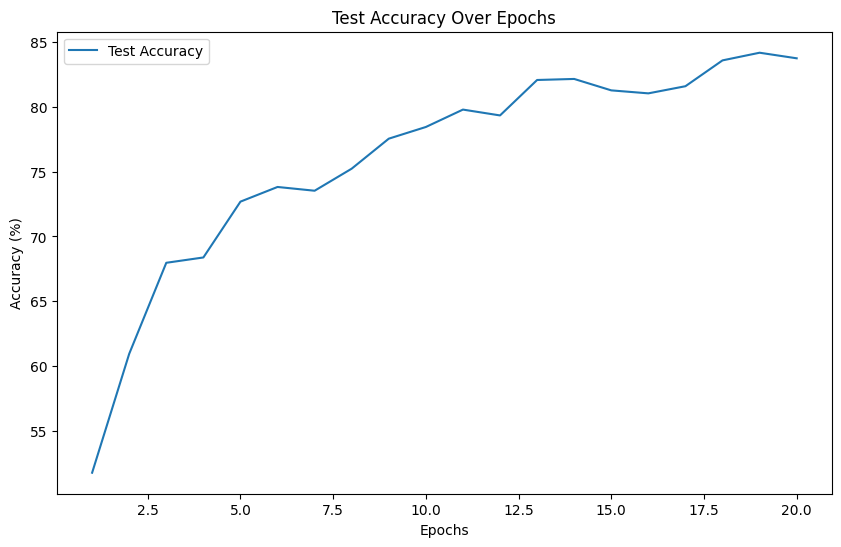

Model saved as advanced_cnn_cifar10.pth


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 20
num_classes = 10

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation
    transforms.RandomHorizontalFlip(),    # Randomly flip images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model
class AdvancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the model
model = AdvancedCNN(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
train_losses, test_losses, test_accuracies = [], [], []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(train_loss / len(train_loader))

    # Evaluate the model on test data
    model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), "advanced_cnn_cifar10.pth")
print("Model saved as advanced_cnn_cifar10.pth")